In [97]:
import matplotlib.pyplot as plt
import pickle

In [98]:
%load_ext autoreload
%autoreload 2
from LayoutUtils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
with open('testGraph.pkl', 'rb') as file:
    molecules_G = pickle.load(file)

In [100]:
def load_parse_molecules(molecules_G):
    node_data = molecules_G["layout_spec"].nodes(data=True)
    edge_data = molecules_G["layout_spec"].edges(data=True)
    print(edge_data)
    node_data = dict(node_data)
    group_id_room_number = {}

    for i, data in node_data.items():
        group_id_room_number[i] = 2 if len(data['data']) == 1 else len(data['data'])

    group_sizes = list(group_id_room_number.values())
    num_rooms = sum(group_sizes)
    group_ids = [k for k, v in node_data.items()]
    groups_to_connect = [(edge[0], edge[1]) for edge in edge_data]

    obstacles = {}
    for tuple_ in edge_data:
        obstacles[tuple_[2]['obstacle_id']] = (tuple_[0], tuple_[1])
    obstacles = {key+30: value for key, value in obstacles.items()}

    return node_data, num_rooms, group_sizes, group_ids, groups_to_connect, obstacles

In [101]:
node_data, num_rooms, group_sizes, group_ids, groups_to_connect, obstacle_ids = load_parse_molecules(molecules_G)
print(obstacle_ids)

[(2, 1, {'obstacle_id': 2}), (1, 0, {'obstacle_id': 44})]
{32: (2, 1), 74: (1, 0)}


In [102]:
print(num_rooms)
print(group_sizes)
print(group_ids)
print(groups_to_connect)

7
[2, 3, 2]
[2, 1, 0]
[(2, 1), (1, 0)]


In [103]:
num_columns = 4
grid_size = 30
min_room_size = 3
roomspace = grid_size - (num_columns + 1)

In [104]:
divisions = get_divisions(roomspace, num_columns, min_room_size)
walkable_points, chosen_rooms = get_choosen_rooms(divisions, min_room_size, num_rooms)

distances = {}
for i, r1 in enumerate(chosen_rooms):
    for j, r2 in enumerate(chosen_rooms):
        if i < j:
            distances[(i, j)] = get_distance(r1, r2)

sorted_pairs = list(sorted(map(lambda x: (x[0], x[1]), distances.items()), key=lambda x: x[1]))
G = get_grid_graph(grid_size, walkable_points, chosen_rooms)
paths = get_paths(G, sorted_pairs, chosen_rooms, grid_size)
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points = get_room_points(chosen_rooms)
room_G = get_rooms_graph(chosen_rooms, paths_lst, rooms_points)

In [105]:
available_indices = set(range(num_rooms))  # num rooms=součet

splits_it = iterate_G(available_indices, group_sizes, 0, room_G)

found = False
for i, split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels) == len(group_sizes):
            crossing_edges = get_crossing_edges_list(skels, room_G, groups_to_connect, paths_lst)
            #if None in crossing_edges:
            #    print(crossing_edges)
            #    continue
            found = True
            print(i, '::::', skels)
            break
    #if i>100:
    if found == True:
        break
#crossing_edges = [] # zakomentovat
#string = get_layout_str(walkable_points,skels,crossing_edges,paths_lst,grid_size)
#print(string)

[(15, (2, 1)), (0, (1, 0))]
0 :::: [{'edges': {13}, 'intersections': {8, 19}}, {'edges': {14, 7}, 'intersections': {16, 18, 20, 15}}, {'edges': {5}, 'intersections': set()}]


In [106]:
def intersect_first_group(corridor_id, groups, room_G, skels, paths_lst):
    group1 = groups[0]
    group2 = groups[1]
    rooms, corridor_points = paths_lst[corridor_id]
    rooms_points = [get_points_from_room(i, room_G) for i in rooms]
    rooms_points = [tuple for sublist in rooms_points for tuple in sublist]
    rooms_points = set(rooms_points)
    corridor_points = set(corridor_points)
    corridor_points = corridor_points.difference(set(rooms_points))
    vertices_edges_dict = nx.get_edge_attributes(room_G, 'corridor_key')
    vertices_edges_dict_inv = {v: k for k, v in vertices_edges_dict.items()}
    group1_points = get_points_from_group(group1, skels, vertices_edges_dict_inv, room_G, paths_lst)
    group2_points = get_points_from_group(group2, skels, vertices_edges_dict_inv, room_G, paths_lst)
    intersect_1 = group1_points.intersection(corridor_points)
    intersect_2 = group2_points.intersection(corridor_points)
    assert not (len(intersect_1) != 0 and len(intersect_2) != 0)
    return len(intersect_1) != 0

In [107]:
vertices_edges_dict = nx.get_edge_attributes(room_G, 'corridor_key')

In [108]:
def get_rooms_from_skels(skels, vertices_edges_dict):
    result = {}
    for i, d in enumerate(skels):
        rooms = []
        for v in vertices_edges_dict.items():
            if v[1] in d['edges']:
                rooms.append(v[0])
        result[i] = rooms
    return result

In [109]:
skels_rooms_dict = get_rooms_from_skels(skels, vertices_edges_dict)

In [110]:
skels_rooms_dict

{0: [(0, 1)], 1: [(2, 3), (2, 4)], 2: [(5, 6)]}

In [111]:
def get_room_ids_for_group(skels_rooms_dict):
    ret = {}
    for k, v in skels_rooms_dict.items():
        temp = []
        for i in v:
            temp += list(i)
        ret[k] = set(temp)
    return ret

In [112]:
room_ids_from_node_data = get_room_ids_for_group(skels_rooms_dict)

In [113]:
def get_obstacle_room(corridor_id, groups, room_G, skels, paths_lst, room_ids_from_node_data):
    intersect = intersect_first_group(corridor_id, groups, room_G, skels, paths_lst)
    room1 = paths_lst[corridor_id][0][0]
    room2 = paths_lst[corridor_id][0][1]
    r1_in_g1 = room1 in room_ids_from_node_data[groups[0]]
    if r1_in_g1:
        rooms = [room1, room2]
    else:
        rooms = [room2, room1]
    if intersect:
        obstacle_room = rooms[1]
    else:
        obstacle_room = rooms[0]
    return obstacle_room

In [114]:
def get_line_around_room(path):
    border = []
    for p in path:
        border += get_neighs(p)
    surrounding_nodes = list(set(border) - set(path))
    return surrounding_nodes

def get_obstacle_pos(room_id, corridor_id, paths_lst,room_G):
    room_points= get_points_from_room(room_id, room_G)
    corridor_points = paths_lst[corridor_id][1]
    room_points = set(room_points)
    corridor_points = set(corridor_points)
    assert len(corridor_points.intersection(room_points))!=0
    corridor_points = corridor_points.difference(room_points)
    room_border = set(get_line_around_room(room_points))
    obstacle_pos = list(room_border.intersection(corridor_points))
    assert len(obstacle_pos)==1
    return obstacle_pos[0]

In [115]:
idx = crossing_edges[0][0]
grps = crossing_edges[0][1]
intersect = intersect_first_group(idx, grps, room_G, skels, paths_lst)
print(intersect)

False


In [116]:
#1. fce která vezme crossing_edges jako argument a vrátí list tuplů, kde každý tuple je obstacle_id a druhý prvek jeho pozice, vrátí obstacles a tu pak do fce. create string
# iterovat přes crossing_edges, vždy vytáhnout idx a groups, groups řekne které dvě groupy propojuje
# na edgich z picklu je uložené obstacle_id, zavolat get_obstacle_room a get_obstacle_pos. (tuple obstacle_id a pozice) append to pole a return
#2. fce
# 2 dicty - jeden z ID na symbol a druhý ze symbolu na ID (prvních n symbolů)
# 50 symbolů je pro submolekuly a 50 symbolů je pro finální molekuly (taky parametrizovat)

In [117]:
obstacle_room_id = get_obstacle_room(idx, grps, room_G, skels, paths_lst, room_ids_from_node_data)
obstacle_pos = get_obstacle_pos(obstacle_room_id,idx,paths_lst,room_G)

In [118]:
# 1. skels edge spojuje 2 roomky (20 - edge spojuje 2 vrcholy (roomy))
# 2. funkce bude vracet list množin (počet množin = počet group, každá množina bude mít tolik prvků - indexů roomek, kolik je v groupě roomek)
# 3. ke každé groupě znám které symboly patří do těch jednotlivých roomek (dle indexů)
#   - funkce vezme index roomky z kroku 2 a počet atomů a vrátí pozice rovnající se počtu atomů, které nesmí být stejné, pozice přiřadím atomům které v té roomce mají být
#### - pro každou roomku vzít atomy, index roomky z kroku 2 a funkce vrátí
# skels:
# {0: [(0, 1)], 1: [(2, 4), (2, 3)], 2: [(5, 6)]}
# room_ids from groups node_data:
# {2: {0, 1}, 1: {2, 3, 4}, 0: {5}}
# node_data:
# {2: {'data': [['13'], ['8', '7']]},
# 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
# 0: {'data': [['17']]}}

In [119]:
node_data

{2: {'data': [['13'], ['8', '7']]},
 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
 0: {'data': [['17']]}}

In [120]:
from collections import defaultdict


def get_room_points_from_node_data(room_ids_from_node_data, room_G):
    room_points = defaultdict(list)
    for k, v in room_ids_from_node_data.items():
        for room_id in v:
            room_points[k].append((room_id, get_points_from_room(room_id, room_G)))
    return room_points

In [121]:
groups_rooms_points = get_room_points_from_node_data(room_ids_from_node_data, room_G)
groups_rooms_points

defaultdict(list,
            {0: [(0,
               [(16, 21),
                (16, 22),
                (16, 23),
                (17, 21),
                (17, 22),
                (17, 23),
                (18, 21),
                (18, 22),
                (18, 23),
                (19, 21),
                (19, 22),
                (19, 23),
                (20, 21),
                (20, 22),
                (20, 23),
                (21, 21),
                (21, 22),
                (21, 23),
                (22, 21),
                (22, 22),
                (22, 23)]),
              (1,
               [(20, 0),
                (20, 1),
                (20, 2),
                (21, 0),
                (21, 1),
                (21, 2),
                (22, 0),
                (22, 1),
                (22, 2),
                (23, 0),
                (23, 1),
                (23, 2),
                (24, 0),
                (24, 1),
                (24, 2),
                (25,

In [122]:
node_data

{2: {'data': [['13'], ['8', '7']]},
 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]},
 0: {'data': [['17']]}}

In [123]:
import random
from collections import defaultdict


def get_atom_placements(groups_rooms_points, node_data, obstacles):
    result = defaultdict(list)
    for k, v in node_data.items():
        idx_g = k
        for i, data in enumerate(v["data"]):
            used_points = []
            for idx, coords in obstacles:
                used_points.append(coords)
            room_points = groups_rooms_points[k][i][1]
            for symbol_id in data:
                while True:
                    sampled_point = random.sample(room_points, 1)[0]
                    if sampled_point not in used_points:
                        result[groups_rooms_points[k][i][0]].append((symbol_id, sampled_point, k))
                        used_points.append(sampled_point)
                        print(used_points)
                        break
                    #Vrací dict listů, kde klíč je ID roomky, value je list tuplů kde prvním prvkem je id atomu a druhým prvkem je (tuple) pozice umístění atomu v roomce.
                    # 1: [('8', (8, 13)), ('7', (9, 14))]

    return result


In [124]:
def get_obstacle_id_and_pos(crossing_edges, room_G, skels, paths_lst, room_ids_from_node_data):
    obstacles = []
    for c_e in crossing_edges:
        idx = c_e[0]
        groups = c_e[1]
        print(groups)
        ob_room = get_obstacle_room(idx, groups, room_G, skels, paths_lst, room_ids_from_node_data)
        ob_pos = get_obstacle_pos(ob_room, idx, paths_lst, room_G)
        ob_pos = toL(ob_pos)
        group_list = []
        for k, v in obstacle_ids.items():
            group_list.append(groups)
            if v in group_list:
                ob_id = k
        obstacles.append((ob_id, ob_pos))
    return obstacles

In [125]:
idx = crossing_edges[1][0]
groups = crossing_edges[1][1]
ob_room = get_obstacle_room(idx, groups, room_G, skels, paths_lst, room_ids_from_node_data)
ob_pos = get_obstacle_pos(ob_room, idx, paths_lst, room_G)
print(ob_pos)

(19, 20)


In [126]:
obstacles = get_obstacle_id_and_pos(crossing_edges, room_G, skels, paths_lst, room_ids_from_node_data)
obstacles

(2, 1)
(1, 0)


[(32, (14, 21)), (74, (20, 21))]

In [127]:
atom_placements = get_atom_placements(groups_rooms_points, node_data, obstacles)
print(atom_placements)

[(14, 21), (20, 21), (12, 21)]
[(14, 21), (20, 21), (16, 25)]
[(14, 21), (20, 21), (16, 25), (15, 26)]
[(14, 21), (20, 21), (10, 1)]
[(14, 21), (20, 21), (15, 8)]
[(14, 21), (20, 21), (15, 8), (20, 4)]
[(14, 21), (20, 21), (15, 8), (20, 4), (20, 14)]
[(14, 21), (20, 21), (0, 21)]
[(14, 21), (20, 21), (0, 21), (3, 23)]
[(14, 21), (20, 21), (0, 21), (3, 23), (6, 23)]
[(14, 21), (20, 21), (0, 21), (3, 23), (6, 23), (2, 21)]
[(14, 21), (20, 21), (17, 21)]
defaultdict(<class 'list'>, {5: [('13', (12, 21), 2)], 6: [('8', (16, 25), 2), ('7', (15, 26), 2)], 2: [('15', (10, 1), 1)], 3: [('8', (15, 8), 1), ('19', (20, 4), 1), ('13', (20, 14), 1)], 4: [('19', (0, 21), 1), ('8', (3, 23), 1), ('7', (6, 23), 1), ('0', (2, 21), 1)], 0: [('17', (17, 21), 0)]})


In [128]:
print(atom_placements)

defaultdict(<class 'list'>, {5: [('13', (12, 21), 2)], 6: [('8', (16, 25), 2), ('7', (15, 26), 2)], 2: [('15', (10, 1), 1)], 3: [('8', (15, 8), 1), ('19', (20, 4), 1), ('13', (20, 14), 1)], 4: [('19', (0, 21), 1), ('8', (3, 23), 1), ('7', (6, 23), 1), ('0', (2, 21), 1)], 0: [('17', (17, 21), 0)]})


In [129]:
def get_atom_obstacle_ids_and_positions(atoms, obstacles):
    atoms_pos_lst = []
    for key in atoms:
        for pair in atoms[key]:
            tuple = pair[1]
            idx = int(pair[0])
            tol = toL(tuple)
            atoms_pos_lst.append((idx,tol))
    merged_list = obstacles + atoms_pos_lst
    all_pos_dic = {v: k for k, v in merged_list}
    if len(merged_list) != len(all_pos_dic):
        print("some atoms/obstacles have same placements")
        print(len(merged_list))
        print(merged_list)
        print(len(all_pos_dic))
        print(all_pos_dic)
    return all_pos_dic


In [130]:
def convert_to_ascii(all_pos_dic):
    print(len(all_pos_dic))
    symbols = [chr(i) for i in range(33, 123) if i not in [119, 65, 97, 87]]
    symbol_map = {}
    for i in range(0, 86):
        symbol_map[i] = symbols[i]
    print(symbol_map)
    new_all_pos_dic = {}
    for k, v in all_pos_dic.items():
        new_all_pos_dic[k] = symbol_map[v]
    print(len(new_all_pos_dic))
    return new_all_pos_dic


In [131]:
atom_obstacles_dict = get_atom_obstacle_ids_and_positions(atom_placements, obstacles)
atom_obstacles_dict

{(14, 21): 32,
 (20, 21): 74,
 (13, 22): 13,
 (17, 26): 8,
 (16, 27): 7,
 (11, 2): 15,
 (16, 9): 8,
 (21, 5): 19,
 (21, 15): 13,
 (1, 22): 19,
 (4, 24): 8,
 (7, 24): 7,
 (3, 22): 0,
 (18, 22): 17}

In [132]:
atom_obstacles_dict_converted = convert_to_ascii(atom_obstacles_dict)
atom_obstacles_dict_converted

14
{0: '!', 1: '"', 2: '#', 3: '$', 4: '%', 5: '&', 6: "'", 7: '(', 8: ')', 9: '*', 10: '+', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '<', 28: '=', 29: '>', 30: '?', 31: '@', 32: 'B', 33: 'C', 34: 'D', 35: 'E', 36: 'F', 37: 'G', 38: 'H', 39: 'I', 40: 'J', 41: 'K', 42: 'L', 43: 'M', 44: 'N', 45: 'O', 46: 'P', 47: 'Q', 48: 'R', 49: 'S', 50: 'T', 51: 'U', 52: 'V', 53: 'X', 54: 'Y', 55: 'Z', 56: '[', 57: '\\', 58: ']', 59: '^', 60: '_', 61: '`', 62: 'b', 63: 'c', 64: 'd', 65: 'e', 66: 'f', 67: 'g', 68: 'h', 69: 'i', 70: 'j', 71: 'k', 72: 'l', 73: 'm', 74: 'n', 75: 'o', 76: 'p', 77: 'q', 78: 'r', 79: 's', 80: 't', 81: 'u', 82: 'v', 83: 'x', 84: 'y', 85: 'z'}
14


{(14, 21): 'B',
 (20, 21): 'n',
 (13, 22): '.',
 (17, 26): ')',
 (16, 27): '(',
 (11, 2): '0',
 (16, 9): ')',
 (21, 5): '4',
 (21, 15): '.',
 (1, 22): '4',
 (4, 24): ')',
 (7, 24): '(',
 (3, 22): '!',
 (18, 22): '2'}

In [133]:
crossing_edge_this = [c_e[0] for c_e in crossing_edges]
print(crossing_edge_this)

[15, 0]


In [134]:

layout = get_layout_str_with_atoms(walkable_points, skels, crossing_edge_this, paths_lst, grid_size, atom_placements, obstacles, atom_obstacles_dict_converted)
print(layout)
# kontrolovat, jestli se neobjeví případ, kdy se protínal crossing_corridor s groupou s obstaclem

wwwwwwwwwwwwwwwwwwwwwwwwwwwwww
wwwwwwwwwwwwwwwwwwwwww4  wwwww
wwwwwwwwwwwwwwwwwwwwww   wwwww
wwwwwwwwwwwwwwwwwwwwww!  wwwww
www                     )wwwww
www wwwwwwwwwwwwwwwwww   wwwww
w   wwwwwwwwwwwwwwwwww   wwwww
w   wwwwwwwwwwwwwwwwww  (wwwww
w   wwwwwwwwwwwwwwwwwwwwwwwwww
w   wwwwwwwwwwwwwwwwww   wwwww
w   wwwwwwwwwwwwwwwwww   wwwww
w 0 wwwwwwwwwwwwwwwwww   wwwww
w   wwwwwwwwwwwwwwwwww   wwwww
w     wwwwwwwwwwwwwwww.  wwwww
wwwww                B   wwwww
wwwwwww wwwwwwwwwwwwww       w
wwwww    )           wwwww ( w
wwwww                w   w)  w
wwwww                w2  wwwww
wwwww                w   wwwww
wwwww                n   wwwww
w   w4         .     w   wwwww
w   wwwwwwwwwwwwwwwwww   wwwww
w   wwwwwwwwwwwwwwww     wwwww
w   www              wwwwwwwww
w   w   wwwwwwwwwwwwwwwwwwwwww
w   w wwwwwwwwwwwwwwwwwwwwwwww
w     wwwwwwwwwwwwwwwwwwwwwwww
w   wwwwwwwwwwwwwwwwwwwwwwwwww
wwwwwwwwwwwwwwwwwwwwwwwwwwwwww



In [135]:
print(skels)

[{'edges': {13}, 'intersections': {8, 19}}, {'edges': {14, 7}, 'intersections': {16, 18, 20, 15}}, {'edges': {5}, 'intersections': set()}]


In [136]:
def checkLayout(skels, crossing_edges, paths_lst, room_points):
    # vytáhnout všechny edges ze skels (pro každou group bude jedno pole edges)
    # edges = [[edge_z_groupy]]
    # loop přes edges a v každé iteraci budu mít všechny edge v dané groupě
    # vytvořit pole všech bodů mimo tuto groupu (všechny roomky a koridory v ostatních groupách)
    # inner přes každý edge:
    # check jestli edge se protíná s čímkoliv co je mimo tuto groupu
    # loop přes všechny crossing_edges
    # zjistit, jestli se neprotínají navzájem (intersection)
    pass

In [137]:
sorted_pairs = list(sorted(map(lambda x: (x[0], x[1]), distances.items()), key=lambda x: x[1]))

In [138]:
G = get_grid_graph(grid_size, walkable_points, chosen_rooms)

In [139]:
paths = get_paths(G, sorted_pairs, chosen_rooms, grid_size)

In [140]:
paths_lst = [(k, v) for k, v in paths.items()]
rooms_points = get_room_points(chosen_rooms)

room_G = get_rooms_graph(chosen_rooms, paths_lst, rooms_points)

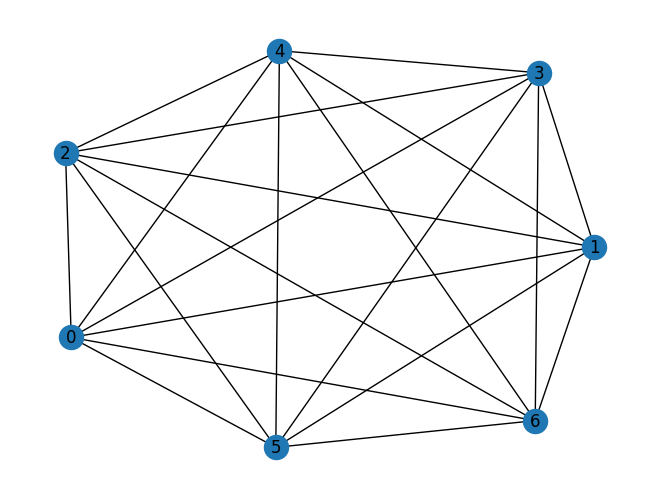

In [141]:
nx.draw(room_G, with_labels=True)
edgs = room_G.edges(data=True)

In [142]:
for e in edgs:
    print(e)

(0, 3, {'corridor_key': 0, 'crossed_corridors': [], 'crossed_rooms': []})
(0, 5, {'corridor_key': 1, 'crossed_corridors': [12], 'crossed_rooms': []})
(0, 6, {'corridor_key': 2, 'crossed_corridors': [8, 19], 'crossed_rooms': []})
(0, 4, {'corridor_key': 12, 'crossed_corridors': [1, 4, 5, 6, 15, 17], 'crossed_rooms': [5]})
(0, 1, {'corridor_key': 13, 'crossed_corridors': [8, 19], 'crossed_rooms': []})
(0, 2, {'corridor_key': 16, 'crossed_corridors': [6, 7, 11, 15, 17], 'crossed_rooms': [3]})
(1, 3, {'corridor_key': 3, 'crossed_corridors': [17], 'crossed_rooms': []})
(1, 2, {'corridor_key': 9, 'crossed_corridors': [20], 'crossed_rooms': []})
(1, 5, {'corridor_key': 17, 'crossed_corridors': [3, 6, 7, 11, 15, 16], 'crossed_rooms': [3]})
(1, 6, {'corridor_key': 19, 'crossed_corridors': [2, 8, 13], 'crossed_rooms': []})
(1, 4, {'corridor_key': 20, 'crossed_corridors': [9, 14, 18], 'crossed_rooms': [2]})
(2, 3, {'corridor_key': 7, 'crossed_corridors': [15, 16], 'crossed_rooms': []})
(2, 4, {'c

In [143]:
groups_to_connect = [(0, 1), (1, 2)]
available_indices = set(range(num_rooms))
splits_it = iterate_G(available_indices, [3, 3, 3], 0, room_G)
found = False
for i, split in enumerate(splits_it):
    skels_it = get_possible_split(split)
    for skels in skels_it:
        if len(skels) == 3:
            crossing_edges = get_crossing_edges_list(skels, room_G, groups_to_connect, paths_lst)
            found = True
            print(i, '::::', skels)
            break
    #if i>100:
    if found == True:
        break

In [144]:
% load_ext autoreload
% autoreload 2
from LayoutUtils import *

string = get_layout_str(walkable_points, skels, [], paths_lst, grid_size)
print(string)

UsageError: Line magic function `%` not found.


In [ ]:
ix = 2


def get_layout_str(walkable_points, skels, crossing_edges):
    edges = []
    for s in skels:
        edges += list(s['edges'])
    edges += crossing_edges
    walkable_points_all = list(walkable_points)
    for ix in edges:
        walkable_points_all += list(map(toL, paths_lst[ix][1]))
    walkable_points_all = set(walkable_points_all)
    string = create_string(walkable_points, grid_size)
    return string

In [ ]:
get_points_from_group(2, skels, vertices_edges_dict_inv, room_G, paths_lst)

In [ ]:

get_points_from_room(1, room_G)

In [ ]:
# skels is a list of skeletons for each group such as the one in the cell above
# [{'edges': {0, 12}, 'intersections': {15, 21, 24, 25, 28, 29}},
# {'edges': {5, 34}, 'intersections': {31, 35}},
# {'edges': {9, 10}, 'intersections': {14}}]
# groups is a tuple of indices (i,j) of the groups which should be connected..it uses the skels list indices
# [0,1]
# setA = get all vertices from group i (use get_vertices_from_edge_ids)
# setB = get all vertices from group j (use get_vertices_from_edge_ids)
# create all possible pairs (crossing edges) where the first element is from setA and the second from setB
# iterate over the crossing edges (refered here as e): (itertools)
# now when we speak about corridors we mean corridors which are present in the skeletons in the skel list
# these corridors are stored in the 'edges' key of a given skeleton
# if the crossing_edge e intersects some room or corridor from some other group than i or j then skip this edge (other groups are present in skels list)
# intA = get intersection between the crossing edge e and anything (either room or chosen corridor) in group i
# intB = same thing but for group j
# if both intA and intB are not empty then skip this crossing edge
# else return this edge

In [ ]:

print(crossing_edges)

In [ ]:

crossing_edges = get_crossing_edges(skels, groups_to_connect, vertices_edges_dict_inv, vertices_edges_dict)
get_edges_from_skels(crossing_edges, groups_to_connect, skels, vertices_edges_dict_inv, room_G, paths_lst,
                     vertices_edges_dict)

In [ ]:
paths_lst[4]